## Navigating Rates

### Summary

Following the spike in USD swaption implied vol last summer, vols have come down materially. When we dissect the moves of the vol surface over the past 2 years, we find that:

* Vols on 1y tails are back at lows while vols on 10y tails haven’t fully retraced from last summer's spike. 
* Skew on 1y tails remains bid for receivers (and payers trade close to flat vs. ATM) while payer skew on 10y tails has richened translating into a flat skew but very high smile (both receiver and payer skews are high). 

Given these findings, we look at a hypothetical scenario analysis of a short 3m10y strangle over time. 


The content of this notebook is split into:
* [1 - Let's get started with gs quant](#1---Let's-get-started-with-gs_quant)
* [2 - Implied volatility in historical context](#2---Implied-volatility-in-historical-context)
* [3 - Skew](#3---Skew)
* [4 - Potential structures](#4---Potential-structures)

### 1 - Let's get started with gs_quant

Start every session with authenticating with your unique client id and secret. If you don't have a registered app, create one [here](https://marquee.gs.com/s/developer/myapps/register). `run_analytics` scope is required for the functionality covered in this example. Below produced using gs-quant version 0.8.95.

In [1]:
from gs_quant.session import GsSession
GsSession.use(client_id=None, client_secret=None, scopes=('run_analytics',)) 

### 2 - Implied volatility in historical context

Let's start by looking at the implied volatility of 1y and 10y payer and receiver swaptions expiring at 3m.

To do that, let's first create the 8 swaptions (2 types x 2 expiries x 2 strikes) and put them in a portfolio. 

In [2]:
from gs_quant.markets.portfolio import Portfolio
from gs_quant.common import Currency, PayReceive
from gs_quant.instrument import IRSwaption

currency = Currency.USD
expiry = '3m'
notional = 1e8

tenors = ['1y', '10y']
r_strikes = ['ATMF', 'ATMF-50']
p_strikes = ['ATMF', 'ATMF+50']

receivers = [ IRSwaption(PayReceive.Receive, tenor, currency, expiration_date=expiry, strike=strike, notional_amount=notional, name='{},{},{}'.format('R',tenor,strike)) for strike in r_strikes for tenor in tenors ]
payers = [ IRSwaption(PayReceive.Pay, tenor, currency, expiration_date=expiry, strike=strike, notional_amount=notional, name='{},{},{}'.format('P',tenor,strike)) for strike in p_strikes for tenor in tenors ]

swaptions = payers + receivers
port = Portfolio(swaptions)

Let's now calculate annualized implied volatility for the last two years looking at month ends as well as the most recent date.

In [3]:
from gs_quant.markets import HistoricalPricingContext
from gs_quant.risk import IRAnnualImpliedVol
import pandas as pd
import datetime as dt

dates = pd.date_range('2018-01-01', '2020-01-01', freq='BM').date.tolist()
dates.append(dt.date(2020,1,24))

with HistoricalPricingContext(dates=dates): 
    vols = port.calc(IRAnnualImpliedVol)

We can now construct a dataframe with the results and plot it.

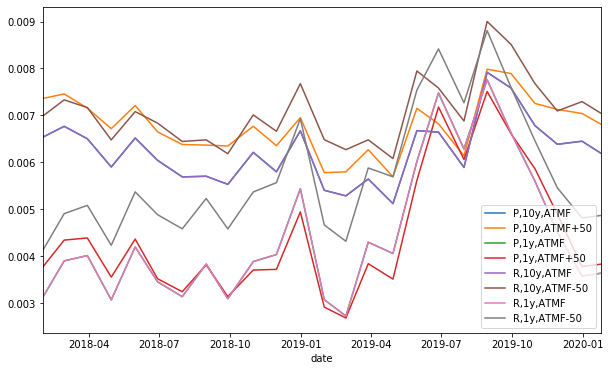

In [4]:
import matplotlib.pyplot as plt

d = pd.DataFrame({s.name: vols[s.name] for s in swaptions})
d.plot(figsize=(10,6))

As we can see in the charts above, implied vol for both 1y and 10y tenors has come in since 2019 highs but significantly more so for 1y tenor than 10y.

### 3 - Skew 

Let's now use the same data to take a look at skew.

In [5]:
receiverSkew3m10y = d['R,10y,ATMF-50'] - d['R,10y,ATMF']
payerSkew3m10y = d['P,10y,ATMF+50'] - d['P,10y,ATMF']

receiverSkew3m1y = d['R,1y,ATMF-50'] - d['R,1y,ATMF']
payerSkew3m1y = d['P,1y,ATMF+50'] - d['P,1y,ATMF']

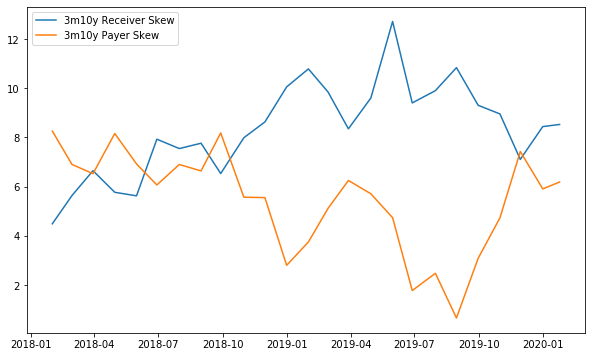

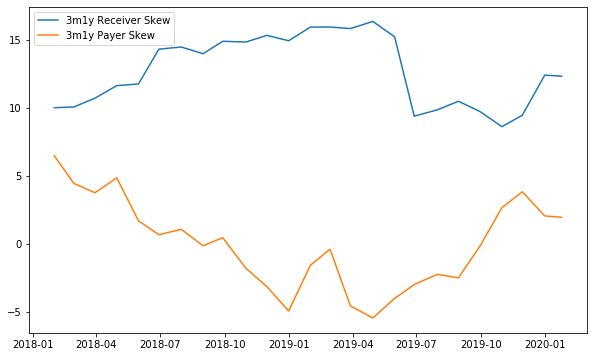

In [6]:
plt.figure(figsize=(10,6))
plt.plot(receiverSkew3m10y*10000,label='3m10y Receiver Skew')
plt.plot(payerSkew3m10y*10000,label='3m10y Payer Skew')
plt.legend(loc="upper left")
plt.show()

plt.figure(figsize=(10,6))
plt.plot(receiverSkew3m1y*10000, label='3m1y Receiver Skew')
plt.plot(payerSkew3m1y*10000, label='3m1y Payer Skew')
plt.legend(loc="upper left")
plt.show()

In the charts above we can see that 3m10y payer and receiver skew remains high but the spread between them has tightened. For the 1y tenor, however, the payer skew has flattened while receiver skew remains rich in the context of the last 2 years. 

### 4 - Potential structures

Let's now look at a 3m10y F+/-25 strangle to fade the steep vol smile. 

For this exercise, we will age it in a roll to spot scenario. 

In [7]:
strangles = {}
labels = ['Inception', 'After 1m', 'After 2m', 'After 3m']

# calc fixed strikes
r_rec_strike = IRSwaption(PayReceive.Receive, '10y', Currency.USD, expirationDate='3m', strike='ATMF-25', notionalAmount=1e8).resolve(in_place=False).strike
r_pay_strike = IRSwaption(PayReceive.Pay, '10y', Currency.USD, expirationDate='3m', strike='ATMF+25', notionalAmount=1e8).resolve(in_place=False).strike

for i, expiry in enumerate(['3m', '2m', '1m', '1d']):
    R = IRSwaption(PayReceive.Receive, '10y', Currency.USD, expirationDate=expiry, strike=r_rec_strike, notionalAmount=1e8)
    P = IRSwaption(PayReceive.Pay, '10y', Currency.USD, expirationDate=expiry, strike=r_pay_strike, notionalAmount=1e8)
    strangle = Portfolio((R,P))
    strangle.resolve()
    strangles[labels[i]] = strangle

Let's now construct a set of spot shocks and examine the impact on price accross the different expiries.

In [15]:
from gs_quant.risk import MarketDataShockBasedScenario, MarketDataPattern, MarketDataShock, MarketDataShockType
from gs_quant.markets import PricingContext
from gs_quant.risk import IRVegaParallel

shocks = [ x for x in range(-50, 55, 5) ]
price_results = []
vega_results = []

with PricingContext():
    for expiry, strangle in strangles.items():
        p_results = pd.Series()
        p_results.name = expiry
        
        v_results = pd.Series()
        v_results.name = expiry
               
        for shock in shocks:
            ir_spot_scenario = MarketDataShockBasedScenario(shocks={
                    MarketDataPattern('IR', 'USD', 'SWAP'): MarketDataShock(MarketDataShockType.Absolute, shock/10000),
                    MarketDataPattern('IR', 'USD', 'CASH'): MarketDataShock(MarketDataShockType.Absolute, shock/10000),    
                    MarketDataPattern('IR', 'USD', 'EURO'): MarketDataShock(MarketDataShockType.Absolute, -shock/10000),
                    MarketDataPattern('IR Reset', 'USD'): MarketDataShock(MarketDataShockType.Absolute, shock/10000)                
                }
            )

            with ir_spot_scenario:
                p_results.at[shock] = strangle.price()
                v_results.at[shock] = strangle.calc(IRVegaParallel)

        price_results.append(p_results)
        vega_results.append(v_results)

We can now roll up the visualize the results:

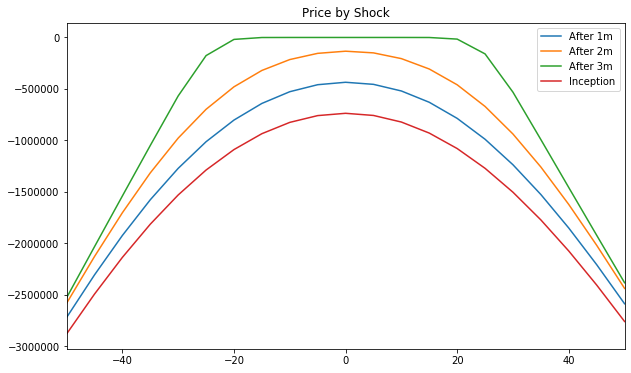

In [9]:
p_res = { s.name: s.apply(lambda x: -x.aggregate()) for s in price_results }
pd.DataFrame(p_res).plot(figsize=(10,6), title='Price by Shock')

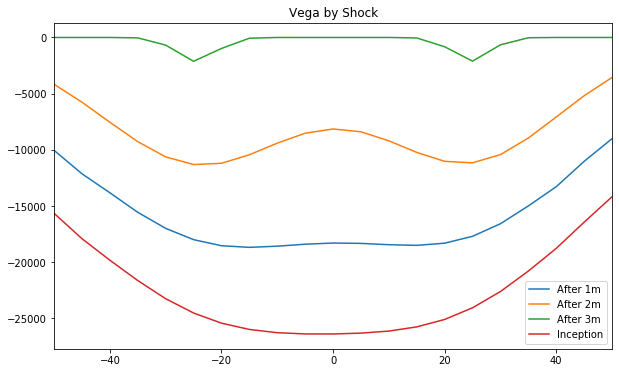

In [10]:
v_res = { s.name: s.apply(lambda x: -x.aggregate()) for s in vega_results }
pd.DataFrame(v_res).plot(figsize=(10,6), title='Vega by Shock')

Finally let's look at our breakevens as we move from inception to expiry.

In [11]:
df = pd.DataFrame(p_res).reindex(range(-50,50)).interpolate()
breakeven = df.loc[0]['Inception']

In [12]:
from gs_quant.risk import IRSpotRate
spot = strangles['Inception'][0].calc(IRSpotRate) * 100

In [13]:
top = pd.Series()
bottom = pd.Series()

for column in df.columns:
    sl = df.iloc[(df[column]-breakeven).abs().argsort()[:2]]
    a, b = sl[column].index
    top.at[column] = a if a >= 0 else b
    bottom.at[column] = a if a < 0 else b

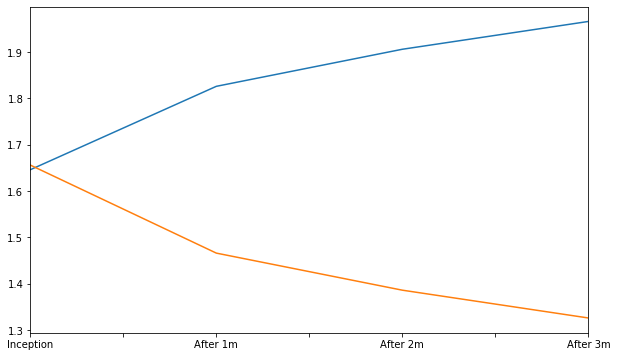

In [14]:
(top/100 + spot).reindex(labels).plot(figsize=(10,6))
(bottom/100 + spot).reindex(labels).plot(figsize=(10,6))

Please reach out to `gs-quant@gs.com` with any questions.

### Disclaimer
This website may contain links to websites and the content of third parties ("Third Party Content"). We do not monitor, review or update, and do not have any control over, any Third Party Content or third party websites. We make no representation, warranty or guarantee as to the accuracy, completeness, timeliness or reliability of any Third Party Content and are not responsible for any loss or damage of any sort resulting from the use of, or for any failure of, products or services provided at or from a third party resource. If you use these links and the Third Party Content, you acknowledge that you are doing so entirely at your own risk.